### 0. Load & View Dataset

In [1]:
## Import libraries
import pandas as pd
import numpy as np

In [2]:
## Load dataset
df = pd.read_csv('./Project_1_dataset_01_01_2022.csv')

In [3]:
df.head()

,Unnamed: 0,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,590,Having made a massive impact in Saudi Arabia w...,Having made a massive impact in Saudi Arabia w...,"['singhs', 'rooting', 'cool', 'saudi', 'style'...",NaN,[],https://www.msn.com/en-in/entertainment/other/...,cricket,sports
1,388,Cricket is all about the emotional rollercoast...,"No matter which team fans hope to win, every s...","['wants', 'fans', 'finals', 'cup', 'win', 'tou...",NaN,[],https://www.prnewswire.com:443/news-releases/c...,cricket,sports
2,423,New Zealand announces back-to-back tours next ...,New Zealand announces back-to-back tours next ...,"['test', 'west', 'tour', 'zealand', 'world', '...",2021-12-20 00:00:00,[],https://www.aljazeera.com/news/2021/12/20/cric...,cricket,sports
3,563,It's not the first time cricket fans in the co...,Billed as one of the pre-tournament favourites...,"['qualify', 'afghanistan', 'cup', 'world', 'ze...",NaN,[],https://www.msn.com/en-in/news/other/t20-world...,cricket,sports
4,634,An employee works on a computer terminal again...,"REUTERS/Sivaram VBENGALURU, Oct 11 (Reuters Br...","['success', 'tech', 'startup', 'talent', 'onli...",2021-10-11 00:00:00,['Una Galani'],https://www.reuters.com/breakingviews/india-in...,cricket,sports


In [4]:
df.shape

(2072, 9)

Question 1: There are in total 2072 rows/samples. There are in total 9 columns, however the features describing the 
data are full_text, summary, keywords, publish_date, authors and url (6 in total). Leaf_label and root_label are the dependent variables or classes. Unamed: 0 is an index variable.

#### 0.1 Plot histograms

In [5]:
## Import libraries
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# what happens with infinite bins?

In [7]:
df['count'] =  df['full_text'].apply(lambda x: sum(char.isalnum() for char in x))

In [8]:
## Sanity check - value of count should be in the range of length of string full_text
# df['count'].value_counts

## Sanity check - length of full_text for first row
# len(df['full_text'][0])

In [9]:
# plt.hist(df['count'])
# plt.show()

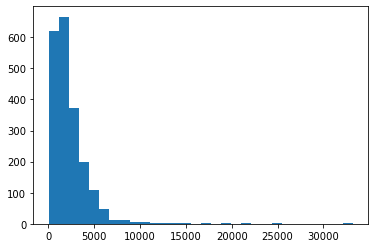

In [10]:
# Frequency plot for number of alpha-numeric characters in full_text
plt.hist(df['count'], 30,
         histtype='bar')

plt.show()

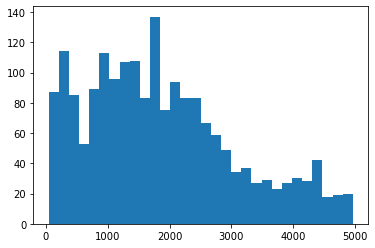

In [11]:
plt.hist(df[df['count']<5000]['count'], 30,
         histtype='bar')

plt.show()

In [12]:
## sanity check
# df['leaf_label'].value_counts()

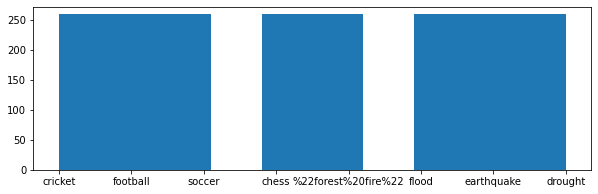

In [13]:
# Frequency plot for leaf_label

plt.figure(figsize=(10,3))
plt.hist(df['leaf_label'],
        histtype='bar')
plt.show()

In [14]:
## sanity check
# df['root_label'].value_counts()

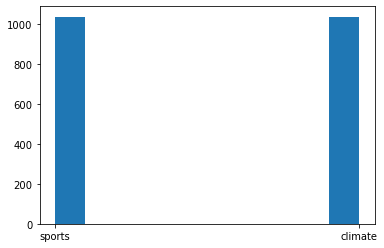

In [15]:
# Frequency plot for root_label

# plt.figure(figsize=(3,3))
plt.hist(df['root_label'],
        histtype='bar')
plt.show()

The first plot suggests that most of the documents have less that 5,000 alpha-numeric characters. Few documents are very long with some having more than 30,000 alpha-numeric characters. The second frequency plot for leaf_label suggests that data is distributed equally among the 8 classes with each class having 259 samples in total. The third plot suggests that for the binary class label root_label, data is distributed equally between the 2 classes sports and climate, with each having 1036 data points.

### 1. Binary Classification

- Use full_text to extract features for binary classification to root_label classes: sports and climate

#### 1.1 Split data

In [16]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [17]:
## Split data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)


In [18]:
print(train.shape)
print(test.shape)

(1657, 10)
(415, 10)


Question 2: There are total 1657 samples in training data and 415 samples in test data.

In [19]:
## check class distribution in train and test

# train['leaf_label'].value_counts(normalize = True)
# test['leaf_label'].value_counts(normalize = True)
# train['root_label'].value_counts(normalize = True)
# test['root_label'].value_counts(normalize = True)

#### 1.2 Feature extraction

In [20]:
## Import libraries
import re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords' )


import string
from string import punctuation

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')


In [21]:
#################################
# FUNCTIONS
#################################

In [22]:
def clean(text):
    '''
    Helps remove many HTML artefacts from the crawler's output.
    '''
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [23]:

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
wnl = nltk.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def penn2morphy(penntag):
    """ 
    Converts Penn Treebank tags to WordNet. 
    """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(list_word): 
    '''
    Returns lemmatized set of tokens with pos tagging
    '''
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc): # this should have been at the sentence-level because the pos-tag performs best at sentence-level
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())


def clean_tokens (tokens: list):
    lower_txt = [token.lower() for token in tokens]
    
    # if lemmatization
#     lemmatize_tokens = lemmatize_sent(lower_txt)  
#     remove_digits = [token for token in lemmatize_tokens if not token.isdigit()]
    # if stemming
    stem_tokens = [stemmer.stem(token) for token in lower_txt] 
    remove_digits = [token for token in stem_tokens if not token.isdigit()]
    
    remove_stopwords = [token for token in remove_digits if token not in combined_stopwords]
    len_token = [token for token in remove_stopwords if len(token)>1]
    return len_token

def doc_tokens (doc):
    list_sentences = sent_tokenize(doc)
    doc_tokens = []
    for sentence in list_sentences:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(sentence)
        tokens = clean_tokens(tokens)
        doc_tokens.extend(tokens)
#     print(doc_tokens)
    return (word for word in doc_tokens)       
    

Ref: https://avielrs.github.io/lemmatization/

Difference between stemming and lemmatization:
    Stemming tries to reduce the word to root/base word which might or might not have actual meaning associated with it. It works by removing siffixes from the words. Stemming can be beneficial when developing search engines for query matching and feature space reduction when training a model. Since, stemming does not take into account the complexities of english language, it might end up changing the meaning of the word entirely for example from does to doe. Also, the resulting words after stemming might be hard to understand as they don't necessarily have a meaning associated. Stemming might be preferred when the meaning of the word is not important. It is also faster than lemmatization.
    Lemmatization on the other hand, is more careful that the word reduction does not lose the meaning of the word. It can also utilize some complexities of english language such as parts of speech in order to return better root words. A downside for lemmatization is that it might end up giving a larger feature set compared to stemming.

In [24]:
# punctuation

In [25]:
#################################
# MAIN
#################################

In [26]:
# train_debug = train[:50]

In [27]:
count_vectorizer = CountVectorizer(min_df=3, stop_words='english', analyzer=doc_tokens, max_df=0.7)
# count_vectorizer = CountVectorizer(stop_words='english', analyzer=doc_tokens)
X_train_counts = count_vectorizer.fit_transform(train['full_text'])

In [28]:
X_train_counts.shape

(1657, 9326)

Lemmatization leads to 10451 keywords, while stemming leads to 9382 keywords. Stemming reduces the dictionary size.

In [29]:
count_vectorizer.get_feature_names()

/Users/reemakumari/.conda/envs/kaggle/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['08837phone',
 '100th',
 '100year',
 '10km',
 '10th',
 '10year',
 '10yearold',
 '11th',
 '11yearold',
 '12th',
 '12yard',
 '13th',
 '13yard',
 '14game',
 '14th',
 '15man',
 '15th',
 '15yard',
 '16th',
 '17f',
 '17inch',
 '17magnitud',
 '17th',
 '17yard',
 '18th',
 '18yearold',
 '19th',
 '19yard',
 '1and4',
 '1st',
 '1yard',
 '20th',
 '20year',
 '21st',
 '21yard',
 '22yard',
 '22yearold',
 '23rd',
 '23yard',
 '23yearold',
 '247sport',
 '24hour',
 '24th',
 '25th',
 '25yearold',
 '26th',
 '27th',
 '28th',
 '28yearold',
 '29th',
 '29yard',
 '29yearold',
 '2am',
 '2nd',
 '2s',
 '2yard',
 '2½',
 '30day',
 '30th',
 '30yard',
 '30yearold',
 '31st',
 '31yearold',
 '32nd',
 '32yard',
 '32yearold',
 '33yard',
 '33yearold',
 '34game',
 '34th',
 '34yard',
 '35liter',
 '360degre',
 '36yard',
 '36yearold',
 '37inch',
 '37th',
 '37yard',
 '37yearold',
 '39yard',
 '3a',
 '3d',
 '3rd',
 '40th',
 '40yard',
 '40yearold',
 '42nd',
 '44yearold',
 '45yard',
 '45yearold',
 '47magnitud',
 '47yard',
 '48yard',

In [30]:
transformer = TfidfTransformer()
X_train_tfidf = transformer.fit_transform(X_train_counts)

In [31]:
min_dfs = range(1,5)
for min_df in min_dfs:
    count_vectorizer1 = CountVectorizer(min_df=min_df, stop_words='english', analyzer=doc_tokens, max_df=0.7)
    X_train_counts1 = count_vectorizer1.fit_transform(train['full_text'])
    
    transformer1 = TfidfTransformer()
    X_train_tfidf = transformer1.fit_transform(X_train_counts1)
    
    print(X_train_tfidf.shape)

(1657, 29631)
(1657, 13316)
(1657, 9326)
(1657, 7413)


Increasing minimum document frequency i.e, minimum number of documents in which the word should appear reduces the size of the vocabulary by removing words that are not descriptive of the set of documents as they occur in very few documents. It will also reduce some high idf (inverse document frequency) values associated with lower minimum document frequency as min_df is increased.

Since lemmatization preserves the meaning of the words, stopwords ....

In [32]:
count_vectorizer = CountVectorizer(min_df=3, stop_words='english', analyzer=doc_tokens, max_df=0.7)
transformer = TfidfTransformer()

X_train_counts = count_vectorizer.fit_transform(train['full_text'])
X_train_tfidf = transformer.fit_transform(X_train_counts)

X_test_counts = count_vectorizer.transform(test['full_text'])
X_test_tfidf = transformer.transform(X_test_counts)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1657, 9326)
(415, 9326)


The shape of tf-idf processed train matrix is (1657, 9382) and the shape of test matrix is (415, 9382). The number of rows matches that in question 2.

#### 1.3 Dimensionality reduction

In [33]:
from sklearn.decomposition import TruncatedSVD, NMF
# contrary to PCA this method does not center the data, hence can work with sparse matrices. understand this.
# understand PCA vs truncated SVD



In [34]:
# Run LSI for various k values
k_list = [1,10,50,100,200,500,1000,2000]
explained_ratio = []
for k in k_list:
    svd = TruncatedSVD(n_components=k, n_iter = 20, random_state=42)
    svd.fit(X_train_tfidf)
    print(svd.explained_variance_ratio_.sum())
    explained_ratio.append(svd.explained_variance_ratio_.sum())

0.005680719937246282
0.120075060180665
0.26733249865519204
0.363088209969505
0.49359820400034476
0.726163585186963
0.9223143266762159
1.0


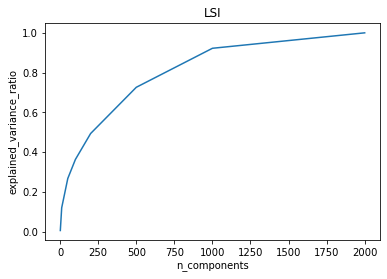

In [35]:
# plotting the explained variance ratio across number of components
plt.plot(k_list, explained_ratio)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')
plt.title('LSI')
plt.show()

Question 4: The plots concavity suggests that as we increase dimensions, the explained variance ratio first increases quickly and then the rate of increase in explained variance ratio decreases with increasing number of dimensions. Explained variance of each eigenvector has diminishing returns.

In [36]:
def get_SVD_residual_MSE (X_train, X_test, k = 50):
    svd = TruncatedSVD(n_components=k, n_iter = 20, random_state=42)
    X_train_svd = svd.fit_transform(X_train)
    VT = svd.components_
    X_train_svd = np.matmul(X_train_svd, VT)
#     print(X_train_svd)
    mse_train = ((X_train.toarray() - X_train_svd)**2).mean(axis=None)
    X_test_svd = svd.transform(X_test)
    X_test_svd = np.matmul(X_test_svd, VT)
    mse_test = ((X_test.toarray() - X_test_svd)**2).mean(axis=None)
    print(mse_train, mse_test)
    
    
    
def get_NMF_residual_MSE (X_train, X_test, k= 50):
    nmf = NMF(n_components=k, init='random', random_state=42)
    X_train_nmf = nmf.fit_transform(X_train)
    H = nmf.components_
    X_train_nmf = np.matmul(X_train_nmf, H)
#     print(X_train_svd)
    mse_train = ((X_train.toarray() - X_train_nmf)**2).mean(axis=None)
    X_test_nmf = nmf.transform(X_test)
    X_test_nmf = np.matmul(X_test_nmf, H)
    mse_test = ((X_test.toarray() - X_test_nmf)**2).mean(axis=None)
    print(mse_train, mse_test)
    

In [37]:
# svd = TruncatedSVD(n_components=50, n_iter = 20, random_state=42)
# X_train_svd = svd.fit_transform(X_train_tfidf)
# VT = svd.components_
# X_train_svd = np.matmul(X_train_svd, VT)

In [38]:
get_SVD_residual_MSE(X_train_tfidf, X_test_tfidf)

7.585568825839525e-05 7.729591315198664e-05


In [39]:
get_NMF_residual_MSE(X_train_tfidf, X_test_tfidf)

7.740124417013825e-05 7.834903942213096e-05


NMF has larger error compared to SVD. This is because .....

#### 1.4 Classification algorithms

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [41]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    prob_score = pipe.predict_proba(test_data)

    fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
    return pipe

In [42]:
## svm

In [43]:
## logistic regression
# plot the ROC
# curve and report the confusion matrix and calculate the accuracy, recall precision and F-1
# score of this classifier on the testing set.
## 1000 features has 92% explained variance

k = 50

## train the model

## define model
count_vectorizer = CountVectorizer(min_df=3, stop_words='english', analyzer=doc_tokens, max_df=0.7)
transformer = TfidfTransformer()
svd = TruncatedSVD(n_components=k, n_iter = 20, random_state=42)
clf = LogisticRegression(penalty = 'none', random_state=42)
label_encoder = LabelEncoder()

## train model
y_train = label_encoder.fit_transform(train['root_label'])
# print(y_train)
X_train_counts = count_vectorizer.fit_transform(train['full_text'])
X_train_tfidf = transformer.fit_transform(X_train_counts)
X_train_svd = svd.fit_transform(X_train_tfidf)
model = clf.fit(X_train_svd, y_train)

## get train parameters

## test model
y_test = label_encoder.transform(test['root_label'])
X_test_counts = count_vectorizer.transform(test['full_text'])
X_test_tfidf = transformer.transform(X_test_counts)
X_test_svd = svd.transform(X_test_tfidf)
y_test_pred = clf.predict(X_test_svd)





/Users/reemakumari/.conda/envs/kaggle/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------
Confusion matrix on test set is: 
[[198   8]
 [  3 206]]
--------------------
--------------------
Performance metrics on test set is: 
Precision is:  0.9626168224299065
Recall is:  0.9856459330143541
Accuracy is:  0.9734939759036144
F1 score is:  0.9739952718676123
--------------------
--------------------
ROC curve on test set is: 


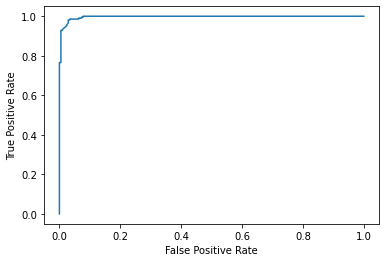

In [44]:
## get test parameters
print('-'*20)
print("Confusion matrix on test set is: ")
print(confusion_matrix(y_test, y_test_pred))
print('-'*20)
print('-'*20)
print("Performance metrics on test set is: ")
print ("Precision is: ", precision_score(y_test, y_test_pred))
print ("Recall is: ", recall_score(y_test, y_test_pred))
print ("Accuracy is: ", accuracy_score(y_test, y_test_pred))
print ("F1 score is: ", f1_score(y_test, y_test_pred))
print('-'*20)

print('-'*20)
print("ROC curve on test set is: ")
y_test_pred_proba = clf.predict_proba(X_test_svd)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_test_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('-'*20)

print('-'*20)
print ("AUC score is: ", roc_auc_score(y_test, y_test_pred_proba))
print('-'*20)

In [45]:
## Logistic regression with cross validation and L1 regularisation
from sklearn.model_selection import KFold 

#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = LogisticRegression(solver= 'liblinear')
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

NameError: name 'X' is not defined

In [ ]:
## Logistic regression with cross validation and L2 regularisation

In [ ]:
# precision_score(y_test, y_test_pred)

In [ ]:
# from sklearn.preprocessing import LabelEncoder, StandardScaler

# Y = label_encoder.fit_transform(y_train)
# X = StandardScaler().fit_transform(X_train_tfidf_dense)

### Grid Search

In [ ]:
import time
from sklearn.pipeline import Pipeline

In [ ]:
logistic = LogisticRegression(max_iter=10000, tol=0.1)
count_vectorizer = CountVectorizer(min_df=3, stop_words='english', analyzer=stem_rmv_punc)
tfidf = TfidfTransformer()
scaler = StandardScaler(with_mean=False) # not absolutely required but does help
pca = TruncatedSVD()

In [ ]:
#pipeline parameters
    parameters = \
        [ \
            {
                'clf': [LogisticRegression()],
                'clf__alpha': [0.001, 0.1, 1, 10, 100]
            },

            {
                'clf': [LinearSVC()],
                'clf__probability': [True]
            },

            {
                'clf': [GaussianNB()]
            }
        ]

    #evaluating multiple classifiers
    #based on pipeline parameters
    #-------------------------------
    result=[]

    for params in parameters:

        #classifier
        clf = params['clf'][0]

        #getting arguments by
        #popping out classifier
        params.pop('clf')

        #pipeline
        steps = [('tf-idf', TfidfVectorizer()), ('clf',clf)]

        #cross validation using
        #Grid Search
        grid = GridSearchCV(Pipeline(steps), param_grid=params, cv=3)
        grid.fit(features, labels)

        #storing result
        result.append\
        (
            {
                'grid': grid,
                'classifier': grid.best_estimator_,
                'best score': grid.best_score_,
                'best params': grid.best_params_,
                'cv': grid.cv
            }
        )

    #sorting result by best score
    result = sorted(result, key=itemgetter('best score'),reverse=True)

    #saving best classifier
    grid = result[0]['grid']
    joblib.dump(grid, 'classifier.pickle')


In [ ]:
#pipeline parameters
    parameters = \
        [ \
            {
                'clf': [LogisticRegression()],
                'clf__alpha': [0.001, 0.1, 1, 10, 100]
            },

            {
                'clf': [LinearSVC()],
                'tf-idf__stop_words': ['english', None],
                'clf__C': [0.001, 0.1, 1, 10, 100, 10e5],
                'clf__kernel': ['linear', 'rbf'],
                'clf__class_weight': ['balanced'],
                'clf__probability': [True]
            },

            {
                'clf': [GaussianNB()],
                'tf-idf__stop_words': ['english', None],
                'clf__criterion': ['gini','entropy'],
                'clf__splitter': ['best','random'],
                'clf__class_weight':['balanced', None]
            }
        ]

    #evaluating multiple classifiers
    #based on pipeline parameters
    #-------------------------------
    result=[]

    for params in parameters:

        #classifier
        clf = params['clf'][0]

        #getting arguments by
        #popping out classifier
        params.pop('clf')

        #pipeline
        steps = [('tf-idf', TfidfVectorizer()), ('clf',clf)]

        #cross validation using
        #Grid Search
        grid = GridSearchCV(Pipeline(steps), param_grid=params, cv=3)
        grid.fit(features, labels)

        #storing result
        result.append\
        (
            {
                'grid': grid,
                'classifier': grid.best_estimator_,
                'best score': grid.best_score_,
                'best params': grid.best_params_,
                'cv': grid.cv
            }
        )

    #sorting result by best score
    result = sorted(result, key=itemgetter('best score'),reverse=True)

    #saving best classifier
    grid = result[0]['grid']
    joblib.dump(grid, 'classifier.pickle')


In [ ]:
import time
full_time = time.time()
for i in range(36): # let's do some math: cleaning vs. not cleaning (2), stem/lemm/none (3), LSI/NMF (2), Classifiers (3)
    start_time = time.time()
    #cachedir = mkdtemp() # without this, you get results where each iteration takes about 5 minutes on my computer.
    
    pipe = Pipeline(steps=[ 
                       ("vect", count_vectorizer),
                       ('tfidf', tfidf), # please do not split training and testing inside your gridsearch.
                       ("scaler", scaler), 
                       ("pca", pca), 
                       ("logistic", logistic)]) # memory=cachedir), "clf",get the model list)
    
    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        "pca__n_components": [10, 100, 1000], # an upper bound
        "logistic__C": [0.01], # your specific model
        "vect__min_df":[2, 6], # min df = 3,5 - these are currently junk values!
    }
    
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5) # n_jobs is saying how many processes do you want to start concurrently
    # If you are using Google Colab, you need to make sure that you have enough memory. If you don't,
    # your runtime is significantly affected, because the virtual machine will start adding everything to swap memory and 
    # this **really** slows down the processing.
    
    search.fit(X_digits, y_digits)
    print("Best parameter (CV score=%0.3f):" % search.best_score_) 
    # built-in functions exist for this
    # RandomizedSearchCV that you can use as an alternate, but you may not score full points on the search.
    
    print(search.best_params_)
    print("--- %s seconds ---" % (time.time() - start_time))
    rmtree(cachedir)

print("--- %s seconds ---" % (time.time() - full_time))

### Multi-class classification

#### Question 9

In [75]:
from sklearn.naive_bayes import MultinomialNB

In [76]:
map_row_to_class = {0:"chess", 1:"cricket", 2:"soccer", 3:"football", \
                    4:"%22forest%20fire%22", 5:"flood", 6:"earthquake", 7:"drought"}



In [80]:
map_class_to_val = {"chess": 0, "cricket": 1, "soccer": 2, "football": 3, \
                    "%22forest%20fire%22": 4, "flood": 5, "earthquake": 6, "drought": 7}

In [81]:
train['leaf_label'].unique()

array(['flood', 'earthquake', '%22forest%20fire%22', 'cricket', 'drought',
       'football', 'soccer', 'chess'], dtype=object)

In [88]:
## Naive bayes classification

k = 50

## train the model

## define model
count_vectorizer = CountVectorizer(min_df=3, stop_words='english', analyzer=doc_tokens, max_df=0.7)
transformer = TfidfTransformer()
nmf = NMF(n_components=k, init='random', random_state=42)  ## Multinomial NB can take only positive values
clf = MultinomialNB()

## train model
train['leaf_label_encode']= train['leaf_label'].map(map_class_to_val)

y_train = train['leaf_label_encode']
# print(y_train)
X_train_counts = count_vectorizer.fit_transform(train['full_text'])
X_train_tfidf = transformer.fit_transform(X_train_counts)
X_train_nmf = nmf.fit_transform(X_train_tfidf)
model = clf.fit(X_train_nmf, y_train)

## get train parameters

## test model
test['leaf_label_encode']= test['leaf_label'].map(map_class_to_val)

y_test = test['leaf_label_encode']
X_test_counts = count_vectorizer.transform(test['full_text'])
X_test_tfidf = transformer.transform(X_test_counts)
X_test_nmf = nmf.transform(X_test_tfidf)
y_test_pred = clf.predict(X_test_nmf)


/Users/reemakumari/.conda/envs/kaggle/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [89]:
## get test parameters
print('-'*20)
print("Confusion matrix on test set is: ")
print(confusion_matrix(y_test, y_test_pred))
print('-'*20)
print('-'*20)
print("Performance metrics on test set is: ")
print ("Precision is: ", precision_score(y_test, y_test_pred, average = 'macro'))
print ("Recall is: ", recall_score(y_test, y_test_pred, average = 'macro'))
print ("Accuracy is: ", accuracy_score(y_test, y_test_pred))
print ("F1 score is: ", f1_score(y_test, y_test_pred, average = 'macro'))
print('-'*20)


--------------------
Confusion matrix on test set is: 
[[43  0  0  1  1  0  0  1]
 [ 4 45  0  0  0  0  0  1]
 [ 6  0 50  1  1  0  0  0]
 [ 5  1  0 48  0  0  0  1]
 [ 1  0  1  0 47  0  0  0]
 [ 1  0  0  1  3 41  5  2]
 [ 9  0  1  1  2  1 38  5]
 [ 3  0  1  0  0  1  0 42]]
--------------------
--------------------
Performance metrics on test set is: 
Precision is:  0.8696535277084646
Recall is:  0.8578288892516492
Accuracy is:  0.8530120481927711
F1 score is:  0.8549604495349992
--------------------


In [ ]:
## svm classification one vs one

In [90]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import LinearSVC

In [92]:
k = 50

## train the model

## define model
count_vectorizer = CountVectorizer(min_df=3, stop_words='english', analyzer=doc_tokens, max_df=0.7)
transformer = TfidfTransformer()
svd = TruncatedSVD(n_components=k, n_iter = 20, random_state=42) ## Multinomial NB can take only positive values
clf = LinearSVC()
ovo_classifier = OneVsOneClassifier(clf)

## train model
train['leaf_label_encode']= train['leaf_label'].map(map_class_to_val)
y_train = train['leaf_label_encode']
# print(y_train)
X_train_counts = count_vectorizer.fit_transform(train['full_text'])
X_train_tfidf = transformer.fit_transform(X_train_counts)
X_train_svd = svd.fit_transform(X_train_tfidf)
model = ovo_classifier.fit(X_train_svd, y_train)

## get train parameters

## test model
test['leaf_label_encode']= test['leaf_label'].map(map_class_to_val)
y_test = test['leaf_label_encode']
X_test_counts = count_vectorizer.transform(test['full_text'])
X_test_tfidf = transformer.transform(X_test_counts)
X_test_svd = svd.transform(X_test_tfidf)
y_test_pred = ovo_classifier.predict(X_test_svd)


In [93]:
## get test parameters
print('-'*20)
print("Confusion matrix on test set is: ")
print(confusion_matrix(y_test, y_test_pred))
print('-'*20)
print('-'*20)
print("Performance metrics on test set is: ")
print ("Precision is: ", precision_score(y_test, y_test_pred, average = 'macro'))
print ("Recall is: ", recall_score(y_test, y_test_pred, average = 'macro'))
print ("Accuracy is: ", accuracy_score(y_test, y_test_pred))
print ("F1 score is: ", f1_score(y_test, y_test_pred, average = 'macro'))
print('-'*20)


--------------------
Confusion matrix on test set is: 
[[44  0  0  1  0  0  1  0]
 [ 0 49  0  0  0  0  1  0]
 [ 3  1 53  1  0  0  0  0]
 [ 1  0  0 54  0  0  0  0]
 [ 1  0  1  0 46  0  1  0]
 [ 2  0  0  1  2 44  2  2]
 [ 2  0  1  1  1  2 49  1]
 [ 3  0  1  0  1  1  0 41]]
--------------------
--------------------
Performance metrics on test set is: 
Precision is:  0.917321642736628
Recall is:  0.9166358452731487
Accuracy is:  0.9156626506024096
F1 score is:  0.9151995731383523
--------------------


In [ ]:
## svm classification one vs rest

In [99]:
k = 50

## train the model

## define model
count_vectorizer = CountVectorizer(min_df=3, stop_words='english', analyzer=doc_tokens, max_df=0.7)
transformer = TfidfTransformer()
svd = TruncatedSVD(n_components=k, n_iter = 20, random_state=42) ## Multinomial NB can take only positive values
clf = LinearSVC(multi_class = 'ovr', class_weight = 'balanced')
# clf = LinearSVC(multi_class = 'ovr')
# ovr_classifier = OneVsRestClassifier(clf)

## train model
train['leaf_label_encode']= train['leaf_label'].map(map_class_to_val)
y_train = train['leaf_label_encode']
# print(y_train)
X_train_counts = count_vectorizer.fit_transform(train['full_text'])
X_train_tfidf = transformer.fit_transform(X_train_counts)
X_train_svd = svd.fit_transform(X_train_tfidf)
model = clf.fit(X_train_svd, y_train)

## get train parameters

## test model
test['leaf_label_encode']= test['leaf_label'].map(map_class_to_val)
y_test = test['leaf_label_encode']
X_test_counts = count_vectorizer.transform(test['full_text'])
X_test_tfidf = transformer.transform(X_test_counts)
X_test_svd = svd.transform(X_test_tfidf)
y_test_pred = clf.predict(X_test_svd)

In [100]:
## get test parameters
print('-'*20)
print("Confusion matrix on test set is: ")
print(confusion_matrix(y_test, y_test_pred))
print('-'*20)
print('-'*20)
print("Performance metrics on test set is: ")
print ("Precision is: ", precision_score(y_test, y_test_pred, average = 'macro'))
print ("Recall is: ", recall_score(y_test, y_test_pred, average = 'macro'))
print ("Accuracy is: ", accuracy_score(y_test, y_test_pred))
print ("F1 score is: ", f1_score(y_test, y_test_pred, average = 'macro'))
print('-'*20)


--------------------
Confusion matrix on test set is: 
[[43  0  0  1  1  0  1  0]
 [ 0 49  0  0  0  0  0  1]
 [ 1  0 57  0  0  0  0  0]
 [ 0  0  0 54  0  0  1  0]
 [ 1  0  1  0 46  0  1  0]
 [ 2  0  0  1  2 44  2  2]
 [ 1  0  1  1  0  3 50  1]
 [ 2  1  1  0  0  1  0 42]]
--------------------
--------------------
Performance metrics on test set is: 
Precision is:  0.9268681231593947
Recall is:  0.9273917005481986
Accuracy is:  0.927710843373494
F1 score is:  0.9265457913450013
--------------------


### Word Embeddings

GLoVE embeddings - Global vectors for word representation

#### Question 10

Q10 a. Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than
the probabilities themselves?



Ratio of the co-occurence probabilities helps determine the words in context which are relevant in distinguishing two different words and also helps determining which context word is more important for which key word. For example, let the context words be solid, gas, water and fashion being studied to understand the target words ice and steam. The probability of solid given ice (P(solid | ice)) and (P(solid| steam)) by itself does not provide much information but if we take the ratio (P(solid | ice) / (P(solid| steam)) given a corpus, we can see that solid is a relevant word in context of ice compared to steam and can help distinguish between ice and steam. 

Q10 b. In the two sentences: “James is running in the park.” and “James is running for the
presidency.”, would GLoVE embeddings return the same vector for the word running in both
cases? Why or why not?

Since GLoVE is a global vector representation, after being trained on a large corpus using the co-occurence matrix of wordsfrom the corpus, the vector embeddings of the word remain unique. Hence, GLoVE will return same vector for the word "running" in the two sentences. 

Q10 c. What do you expect for the values of,
||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2,
||GLoVE["queen"] - GLoVE["king"]||2 and ||GLoVE["wife"] - GLoVE["husband"]||2 ?
Compare these values.

The distance between the embeddings of queen and king compared to the distance between the embeddings of wife and husband should be of similar value as they both have same semantic relationship. The difference between the queen and king and wife and husband should be close to zero.

Q10 d. Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE
embedding?

Lemmatization would be preferred over stemming before mapping the word to its GLoVE embedding. This is becayse lemmatization with pos tagging is word base reduction on the basis of context of word. Also, lemmatization ensures the reduced word is actually an english word with close meaning to original word.

In [46]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [47]:
queen_king = ((embeddings_dict['king'] - embeddings_dict['queen'])**2)
husband_wife = ((embeddings_dict['husband'] - embeddings_dict['wife'])**2)

In [48]:
(sum(queen_king))**0.5

5.966257954114113

In [49]:
queen_king = np.linalg.norm(embeddings_dict['king'] - embeddings_dict['queen'])
husband_wife = np.linalg.norm(embeddings_dict['husband'] - embeddings_dict['wife'])
queen_king_husband_wife = np.linalg.norm(embeddings_dict['queen'] - embeddings_dict['king'] - \
                                         embeddings_dict['wife'] + embeddings_dict['husband'])

In [50]:
m = np.linalg.norm(embeddings_dict['husband'] - embeddings_dict['badminton'])
print(m)

9.695891


In [51]:
a = (embeddings_dict['king'] - embeddings_dict['queen'])

In [52]:
np.linalg.norm(a)

5.966258

In [53]:
print(queen_king)
print(husband_wife)
print(queen_king_husband_wife)

5.966258
3.1520464
6.1650367


#### Question 11

Train a binary classification model using GLoVE embeddings

In [54]:
## Feature engineering using Glove word embeddings

def get_document_vector (doc_keywords:list, embeddings_dict: dict, embed_size = 300 ):
    '''
    From the list of keywords representing the document, get a document embedding
    '''
    representation = np.zeros(embed_size)
    count = 0
    for word in doc_keywords:
        try:
            embed = embeddings_dict[word]
            count = count+1
            representation = np.add(representation, embed)    
        except:
            count = count
    return (representation / count)
        

In [55]:
def data_to_feature_mapping (data: pd.DataFrame(), embeddings_dict: dict, embed_size = 300):
    feature_map = np.zeros(embed_size)
    for index, row in data.iterrows():
        keywords = row['keywords']
#         print(keywords)
        embed = get_document_vector(keywords, embeddings_dict, embed_size)
        feature_map = np.vstack((feature_map,embed))
    feature_map = feature_map[1:,:]
    return feature_map

In [56]:
len(train)

1657

In [57]:
clf = LogisticRegression(penalty = 'none', random_state=42)
label_encoder = LabelEncoder()

## train model
y_train = label_encoder.fit_transform(train['root_label'])
# print(y_train)
X_train = data_to_feature_mapping(train, embeddings_dict, 300)
model = clf.fit(X_train, y_train)

## get train parameters

## test model
y_test = label_encoder.transform(test['root_label'])
X_test = data_to_feature_mapping(test, embeddings_dict, 300)
y_test_pred = clf.predict(X_test)


/Users/reemakumari/.conda/envs/kaggle/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------
Confusion matrix on test set is: 
[[150  56]
 [ 46 163]]
--------------------
--------------------
Performance metrics on test set is: 
Precision is:  0.7442922374429224
Recall is:  0.7799043062200957
Accuracy is:  0.7542168674698795
F1 score is:  0.7616822429906542
--------------------
--------------------
ROC curve on test set is: 


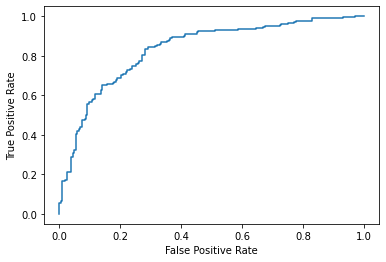

In [58]:
## get test parameters
print('-'*20)
print("Confusion matrix on test set is: ")
print(confusion_matrix(y_test, y_test_pred))
print('-'*20)
print('-'*20)
print("Performance metrics on test set is: ")
print ("Precision is: ", precision_score(y_test, y_test_pred))
print ("Recall is: ", recall_score(y_test, y_test_pred))
print ("Accuracy is: ", accuracy_score(y_test, y_test_pred))
print ("F1 score is: ", f1_score(y_test, y_test_pred))
print('-'*20)

print('-'*20)
print("ROC curve on test set is: ")
y_test_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_test_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Question 12

Trend between embedding size and accuracy

In [59]:
embed_size = [50,100,200,300]

In [60]:
clf = LogisticRegression(penalty = 'none', random_state=42)
label_encoder = LabelEncoder()

## label encoding
y_train = label_encoder.fit_transform(train['root_label'])
y_test = label_encoder.transform(test['root_label'])

## report test accuracy on different embedding size
accuracy = []
for size in embed_size:
    
    embeddings_dict = {}
    with open("glove/glove.6B."+ str(size)+"d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    
    X_train = data_to_feature_mapping(train, embeddings_dict, size)
    model = clf.fit(X_train, y_train)

    X_test = data_to_feature_mapping(test,embeddings_dict, size)
    y_test_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_test_pred))


/Users/reemakumari/.conda/envs/kaggle/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/reemakumari/.conda/envs/kaggle/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [61]:
accuracy

[0.7590361445783133,
 0.7566265060240964,
 0.7542168674698795,
 0.7542168674698795]

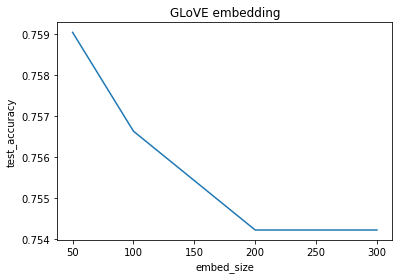

In [62]:
# plotting the explained variance ratio across number of components
plt.plot(embed_size, accuracy)
plt.xlabel('embed_size')
plt.ylabel('test_accuracy')
plt.title('GLoVE embedding')
plt.show()

#### Question 13

Visualize using UMAP

In [68]:
import umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [69]:
size = 300
embeddings_dict = {}
with open("glove/glove.6B."+ str(size)+"d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

X_train = data_to_feature_mapping(train, embeddings_dict, size)

reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(X_train)
embedding = reducer.fit_transform(scaled_data)
embedding.shape

(1657, 2)

Text(0.5, 1.0, 'UMAP projection of the Training dataset')

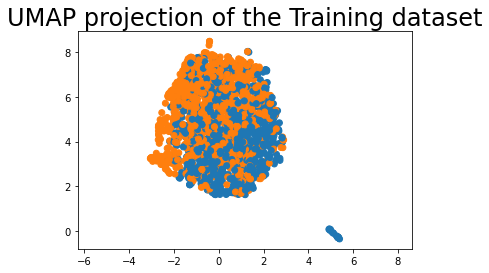

In [70]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in train.root_label.map({"sports":0, "climate":1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Training dataset', fontsize=24)

In [71]:
rand_data = np.random.rand(1657,300)

In [72]:
reducer = umap.UMAP()
scaled_data_rand = StandardScaler().fit_transform(rand_data)
embedding_rand = reducer.fit_transform(scaled_data_rand)
embedding_rand.shape

(1657, 2)

Text(0.5, 1.0, 'UMAP projection of the random dataset')

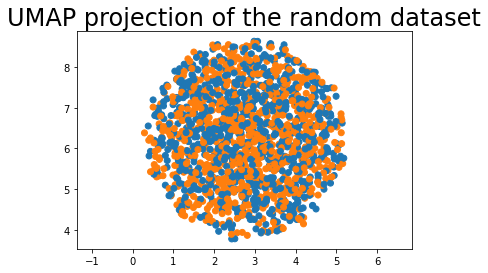

In [73]:
plt.scatter(
    embedding_rand[:, 0],
    embedding_rand[:, 1],
    c=[sns.color_palette()[x] for x in train.root_label.map({"sports":0, "climate":1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the random dataset', fontsize=24)

In [ ]:
###################################### END #######################################

In [ ]:
doc_keywords1 = ['this', 'is', 'my', 'pen']
doc_keywords2 = ['why', 'are', 'you', 'here']

In [ ]:
a = get_document_vector(doc_keywords1)
b = get_document_vector(doc_keywords2)
m = np.zeros(300)
m = np.vstack((m,a))
m = np.vstack((m,b))
# c = np.vstack((a,b))
print(m.shape)

In [ ]:
m = m[1:,:]

In [ ]:
print(m.shape)

In [ ]:
# len(embeddings_dict['king'])

In [ ]:
representation = [0]*300

In [ ]:
representation

In [ ]:
# embeddings_dict['king']

In [ ]:
## logistic regression
# plot the ROC
# curve and report the confusion matrix and calculate the accuracy, recall precision and F-1
# score of this classifier on the testing set.
## 1000 features has 92% explained variance

clf = LogisticRegression(penalty = 'none')

## train the model
CountVectorizer(min_df=3, stop_words='english', analyzer=doc_tokens, max_df=0.7)

pipeline1 = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english', analyzer=doc_tokens, max_df=0.7)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=1000, n_iter = 20, random_state=42)),
    ('clf', clf),
])


In [ ]:
fit_predict_and_plot_roc(pipeline1, twenty_train.data, twenty_train.target, twenty_test.data, twenty_test.target)

In [ ]:
## Provide accuracy bla.. bla.. ---> on test
## take test set -> get ordered list of labels for test set -> get predicted labels

In [ ]:
model = NMF(n_components=50, init='random', random_state=0)
W_train = model.fit_transform(X_train_tfidf)

In [ ]:
def feature_extraction (data: pd.DataFrame()):
    '''
    Module for feature extraction
    '''
    
    ## clean 
    data['clean_full_text'] = data['full_text'].apply(lambda x: clean(x))
    
    ## sentence level data
    data['idx'] = range(1, len(data)+1)
    sent_tokenize(sentence)
    
    
    ## Bag of words
    

In [ ]:
train['clean_full_text'] = train['full_text'].apply(lambda x: clean(x))
train1 = getVectorizer(train, 'clean_full_text')  ## taking time; optimize this; taking even more time :P

In [ ]:
train1.head()

In [ ]:
count_vect = CountVectorizer(stop_words='english', min_df=3, max_df=0.7)
X_train_counts = count_vect.fit_transform(train1['doc_tokens'])

In [ ]:
X_train_counts

In [ ]:
X_train_counts.shape

In [ ]:
m = count_vect.get_feature_names() # remove 00, 000, 00pm etc ....

In [ ]:
X_train_tfidf

In [ ]:
X

In [ ]:
## Latent semantic indexing   ## time taking step
X_train_tfidf_dense = X_train_tfidf.toarray()
U, D, VT = np.linalg.svd(X_train_tfidf_dense)

In [ ]:
U.shape

In [ ]:
D

In [ ]:
k = [1,10,50,100,200,500,1000,2000]

In [ ]:
# def plot_explained_variance (D, k : list):
#     V = np.transpose(VT)
#     explained_ratio = []
#     for k_item in k:
#         V_k = V[:,:k_item]
#         X_reduced = np.dot(X,V_k)

In [ ]:
def plot_explained_variance (D, k : list):
    explained_ratio = []
    tot_variance = sum(D)
    for k_item in k:
        k_variance = sum(D[:k_item])
        explained_ratio.append(k_variance/tot_variance)
    return explained_ratio

In [ ]:
D

In [ ]:
explained_ratio = plot_explained_variance(D, k)

In [ ]:
explained_ratio

In [ ]:
explained_ratio = pd.Series(explained_ratio)
explained_ratio.plot()  ## should be concave; but is convex. check this

In [ ]:
from sklearn.decomposition import NMF
def get_SVD_residual_MSE (X, k = 50):
    U, D, VT = np.linalg.svd(X_train_tfidf_dense)
    V = np.transpose(VT)
    V_k = V[:,:k]
    U_k = U[:,:k]
    D_k = D[:k]
    D_mat = np.diag(D_k)
    X_reconstruct = np.dot(U_k, D_mat)
    X_reconstruct1 = np.dot(X_reconstruct, np.transpose(V_k))
    count = 0
    squared_error = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            squared_error = squared_error + ((X[i][j]-X_reconstruct1[i][j])**2)
            count = count+1
    mse = squared_error/count
    return mse
    
    
def get_NMF_residual_MSE (X, k= 50):
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(X)
    H = model.components_
    X_fit = np.dot(W, H)
    count = 0
    squared_error = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            squared_error = squared_error + ((X[i][j]-X_fit[i][j])**2)
            count = count+1
    mse = squared_error/count
    return mse
    

In [ ]:
get_SVD_residual_MSE(X_train_tfidf_dense)  ## takes time

In [ ]:
X_train_tfidf_dense.shape

In [ ]:
get_NMF_residual_MSE(X_train_tfidf_dense)  ## takes time

In [ ]:
## use root_label for binary classification

In [ ]:
y_train = train['root_label']

In [ ]:
y_train

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(y_train)
X = StandardScaler().fit_transform(X_train_tfidf_dense)

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel = 'linear', C = 1E10)
model.fit(X, Y)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X)
accuracy_score(Y, y_pred)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, Y)
y_pred = clf.predict(X)
accuracy_score(Y, y_pred)

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, Y)
y_pred = clf.predict(X)
accuracy_score(Y, y_pred)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, Y)
y_pred = clf.predict(X)
accuracy_score(Y, y_pred)

In [ ]:
D

In [ ]:
tfidf_transformer.get_feature_names()

In [ ]:
m.to_csv('./m.csv', index = False)

In [ ]:
train1.to_csv('./train1.csv', index = False)

In [ ]:
df1.head()

In [ ]:
df1

In [ ]:
df.columns

In [ ]:
df['full_text'][0]

In [ ]:
a = clean(df['full_text'][0])

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

In [ ]:
sent_tokenize(a)

In [ ]:
for row,index in df:
    print(row['full_text'])
    

In [ ]:
def latent_semantic_indexing (X):
    X_dense = X.toarray()
    U, D, VT = np.linalg.svd(X_dense)